### Импортим библеотеки

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from python_modules import preprocess
from python_modules import visualization
%matplotlib inline
pd.set_option('chained_assignment',None)

### Считываем датасет

| Поле                          | Тип данных         | Описание                                              |
|-------------------------------|--------------------|-------------------------------------------------------|
| premium                       | bool               | Является ли данная вакансия премиум-вакансией       |
| department                    | object             | Департамент                                           |
| has_test                      | bool               | Информация о наличии прикрепленного тестового задания к вакансии |
| response_letter_required      | bool               | Обязательно ли заполнять сообщение при отклике на вакансию |
| salary                        | object             | Зарплата                                             |
| schedule                      | object             | График работы                                         |
| working_days                  | list(object)       | Список рабочих дней                                   |
| working_time_intervals        | list(object)       | Список с временными интервалами работы               |
| working_time_modes            | list(object)       | Список режимов времени работы                        |
| accept_temporary              | bool               | Указание, что вакансия доступна с временным трудоустройством |
| accept_incomplete_resumes     | bool               | Разрешен ли отклик на вакансию неполным резюме       |
| experience                    | object             | Опыт работы                                           |
| employment                    | object             | Тип занятости                                        |
| is_adv_vacancy                | bool               | Является ли вакансия рекламной                      |
| employer_trusted              | bool               | Флаг, показывающий, прошла ли компания проверку на сайте |
| lat                           | float64            | Широта                                                |
| lon                           | float64            | Долгота                                               |
| industry                      | object             | Отрасль компании                                      |


In [4]:
# скачиваем датасет и добавляем признак, ответственный за принадлежность к отрасли
datasets = []
for filename in os.listdir("datasets"):
   with open(os.path.join("datasets/", filename), 'r', encoding='utf-8') as f:
       df = pd.read_json(f, encoding='utf-8')
       df['industry'] = [filename for _ in range(df.shape[0])]
       datasets.append(df)


In [5]:
datasets[0].head()

,premium,department,has_test,response_letter_required,salary,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,accept_incomplete_resumes,experience,employment,is_adv_vacancy,employer_trusted,lat,lon,industry
0,False,None,False,False,"{'from': 25000, 'to': 75000, 'currency': 'RUR'...",Удаленная работа,[],"[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'Можно ...",True,False,Нет опыта,Частичная занятость,False,True,NaN,NaN,"industry(Информационные технологии, системная ..."
1,False,None,False,False,"{'from': 90000, 'to': None, 'currency': 'RUR',...",Удаленная работа,[],[],[],False,True,Нет опыта,Полная занятость,False,True,NaN,NaN,"industry(Информационные технологии, системная ..."
2,False,None,False,False,"{'from': 25000, 'to': 75000, 'currency': 'RUR'...",Удаленная работа,[],"[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'Можно ...",False,False,Нет опыта,Частичная занятость,False,True,NaN,NaN,"industry(Информационные технологии, системная ..."
3,False,None,False,False,"{'from': 100000, 'to': 250000, 'currency': 'RU...",Удаленная работа,[],[],[],True,False,От 3 до 6 лет,Полная занятость,False,True,NaN,NaN,"industry(Информационные технологии, системная ..."
4,False,None,False,False,"{'from': None, 'to': 50000, 'currency': 'RUR',...",Удаленная работа,[],[],[],True,True,От 1 года до 3 лет,Полная занятость,False,True,55.66076,37.54356,"industry(Информационные технологии, системная ..."


Теперь надо сделать препроцесс фич и разбить более комплексные фичи на мелкие, так в колонке address есть нужная информация для станций метро.

### Предварительная обработка

In [6]:
# смотрим какие колонки заполнены и в каких есть пропущенные значения
for dataset in datasets:
    print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5228 entries, 0 to 5227
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   premium                    5228 non-null   bool   
 1   department                 569 non-null    object 
 2   has_test                   5228 non-null   bool   
 3   response_letter_required   5228 non-null   bool   
 4   salary                     5228 non-null   object 
 5   schedule                   5228 non-null   object 
 6   working_days               5228 non-null   object 
 7   working_time_intervals     5228 non-null   object 
 8   working_time_modes         5228 non-null   object 
 9   accept_temporary           5228 non-null   bool   
 10  accept_incomplete_resumes  5228 non-null   bool   
 11  experience                 5228 non-null   object 
 12  employment                 5228 non-null   object 
 13  is_adv_vacancy             5228 non-null   bool 

Видно что поле `department` имеет малое количество вакансий, значит надо избавиться от него. Поля `lat`, `lon` имеют пропущенные значения

In [7]:
# убираем признак департамент
for dataset in datasets:
    dataset.drop(columns=["department"], inplace=True)

In [8]:
datasets[0].head()

,premium,has_test,response_letter_required,salary,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,accept_incomplete_resumes,experience,employment,is_adv_vacancy,employer_trusted,lat,lon,industry
0,False,False,False,"{'from': 25000, 'to': 75000, 'currency': 'RUR'...",Удаленная работа,[],"[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'Можно ...",True,False,Нет опыта,Частичная занятость,False,True,NaN,NaN,"industry(Информационные технологии, системная ..."
1,False,False,False,"{'from': 90000, 'to': None, 'currency': 'RUR',...",Удаленная работа,[],[],[],False,True,Нет опыта,Полная занятость,False,True,NaN,NaN,"industry(Информационные технологии, системная ..."
2,False,False,False,"{'from': 25000, 'to': 75000, 'currency': 'RUR'...",Удаленная работа,[],"[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'Можно ...",False,False,Нет опыта,Частичная занятость,False,True,NaN,NaN,"industry(Информационные технологии, системная ..."
3,False,False,False,"{'from': 100000, 'to': 250000, 'currency': 'RU...",Удаленная работа,[],[],[],True,False,От 3 до 6 лет,Полная занятость,False,True,NaN,NaN,"industry(Информационные технологии, системная ..."
4,False,False,False,"{'from': None, 'to': 50000, 'currency': 'RUR',...",Удаленная работа,[],[],[],True,True,От 1 года до 3 лет,Полная занятость,False,True,55.66076,37.54356,"industry(Информационные технологии, системная ..."


In [9]:
# упрощение столбцов и сохранение атомарных признаков
for dataset in datasets:
    dataset["salary"] = dataset["salary"].apply(preprocess.get_net_salary)
    dataset["industry"] = dataset["industry"].apply(lambda x: x[9:-6])

In [10]:
# считывание станций метро в Москве
stations = np.load("src_files/stations.npy")

In [11]:
# получение признаков из геопозиции: количество ближайших станций и расстояние до ближайшей станции.
for dataset in datasets:
    dataset[["stations_within_km", "distance_to_the_nearest(m)"]] = dataset[["lat", "lon"]].apply(lambda row: pd.Series(preprocess.get_stations_count_and_distance_to_nearest(row, stations)), axis=1)

In [12]:
datasets[0].head()

,premium,has_test,response_letter_required,salary,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,accept_incomplete_resumes,experience,employment,is_adv_vacancy,employer_trusted,lat,lon,industry,stations_within_km,distance_to_the_nearest(m)
0,False,False,False,50000.0,Удаленная работа,[],"[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'Можно ...",True,False,Нет опыта,Частичная занятость,False,True,NaN,NaN,"Информационные технологии, системная интеграци...",NaN,NaN
1,False,False,False,90000.0,Удаленная работа,[],[],[],False,True,Нет опыта,Полная занятость,False,True,NaN,NaN,"Информационные технологии, системная интеграци...",NaN,NaN
2,False,False,False,50000.0,Удаленная работа,[],"[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'Можно ...",False,False,Нет опыта,Частичная занятость,False,True,NaN,NaN,"Информационные технологии, системная интеграци...",NaN,NaN
3,False,False,False,175000.0,Удаленная работа,[],[],[],True,False,От 3 до 6 лет,Полная занятость,False,True,NaN,NaN,"Информационные технологии, системная интеграци...",NaN,NaN
4,False,False,False,50000.0,Удаленная работа,[],[],[],True,True,От 1 года до 3 лет,Полная занятость,False,True,55.66076,37.54356,"Информационные технологии, системная интеграци...",2.0,319.872155


Есть 3 колонки которые могут быть очень полезны для анализа, но достаточно ли там непустых значений?

In [13]:
datasets[0]["working_days"].value_counts()

working_days
[]                                                                          5161
[{'id': 'only_saturday_and_sunday', 'name': 'Работа только по сб и вс'}]      67
Name: count, dtype: int64

In [14]:
datasets[0]["working_time_intervals"].value_counts()

working_time_intervals
[]                                                                                                   4996
[{'id': 'from_four_to_six_hours_in_a_day', 'name': 'Можно работать сменами по 4–6 часов в день'}]     232
Name: count, dtype: int64

In [15]:
datasets[0]["working_time_modes"].value_counts()

working_time_modes
[]                                                                                5026
[{'id': 'start_after_sixteen', 'name': 'Можно начинать работать после 16:00'}]     202
Name: count, dtype: int64

Большинство не имеет данного описания, удаляем эти колонки

In [16]:
# удаление трех столбцов, так как они в основном состоят из пустых значений.
for dataset in datasets:
    dataset.drop(columns=["working_time_modes", "working_time_intervals", "working_days"], inplace=True)

In [17]:
datasets[0].head()

,premium,has_test,response_letter_required,salary,schedule,accept_temporary,accept_incomplete_resumes,experience,employment,is_adv_vacancy,employer_trusted,lat,lon,industry,stations_within_km,distance_to_the_nearest(m)
0,False,False,False,50000.0,Удаленная работа,True,False,Нет опыта,Частичная занятость,False,True,NaN,NaN,"Информационные технологии, системная интеграци...",NaN,NaN
1,False,False,False,90000.0,Удаленная работа,False,True,Нет опыта,Полная занятость,False,True,NaN,NaN,"Информационные технологии, системная интеграци...",NaN,NaN
2,False,False,False,50000.0,Удаленная работа,False,False,Нет опыта,Частичная занятость,False,True,NaN,NaN,"Информационные технологии, системная интеграци...",NaN,NaN
3,False,False,False,175000.0,Удаленная работа,True,False,От 3 до 6 лет,Полная занятость,False,True,NaN,NaN,"Информационные технологии, системная интеграци...",NaN,NaN
4,False,False,False,50000.0,Удаленная работа,True,True,От 1 года до 3 лет,Полная занятость,False,True,55.66076,37.54356,"Информационные технологии, системная интеграци...",2.0,319.872155


В нашем датасете присутствуют вакансии, у которых либо отсутствует адрес, либо они находятся за пределами административных районов Москвы. Однако стоит учитывать, что некоторые из этих вакансий предназначены для удаленной работы, поэтому отсутствие офиса не является необычным явлением. Следовательно, мы должны сохранить такие вакансии в датасете, поскольку жители Москвы вполне могут откликаться на них и работать удаленно.

https://habr.com/ru/companies/ods/articles/338554/

Ресурс помог в визуализации средних зарплат по административным районам Москвы

In [18]:
# получение GeoPandas DataFrame с административными округами Москвы.
mo_gdf = gpd.read_file('src_files/atd/mo.shp')
mo_gdf.head()

,NAME,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO,geometry
0,Киевский,45298555,45945000,Троицкий,45298000,Троицкий,Поселение,"MULTIPOLYGON (((36.80310 55.44083, 36.80319 55..."
1,Филёвский Парк,45268595,45328000,Западный,45268000,ЗАО,Муниципальный округ,"POLYGON ((37.42765 55.74821, 37.42849 55.74875..."
2,Новофёдоровское,45298567,45954000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.80357 55.45162, 36.80451 55.46551..."
3,Роговское,45298575,45956000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.93724 55.24139, 36.93726 55.24161..."
4,"""Мосрентген""",45297568,45953000,Новомосковский,45297000,Новомосковский,Поселение,"POLYGON ((37.43956 55.62731, 37.44018 55.63042..."


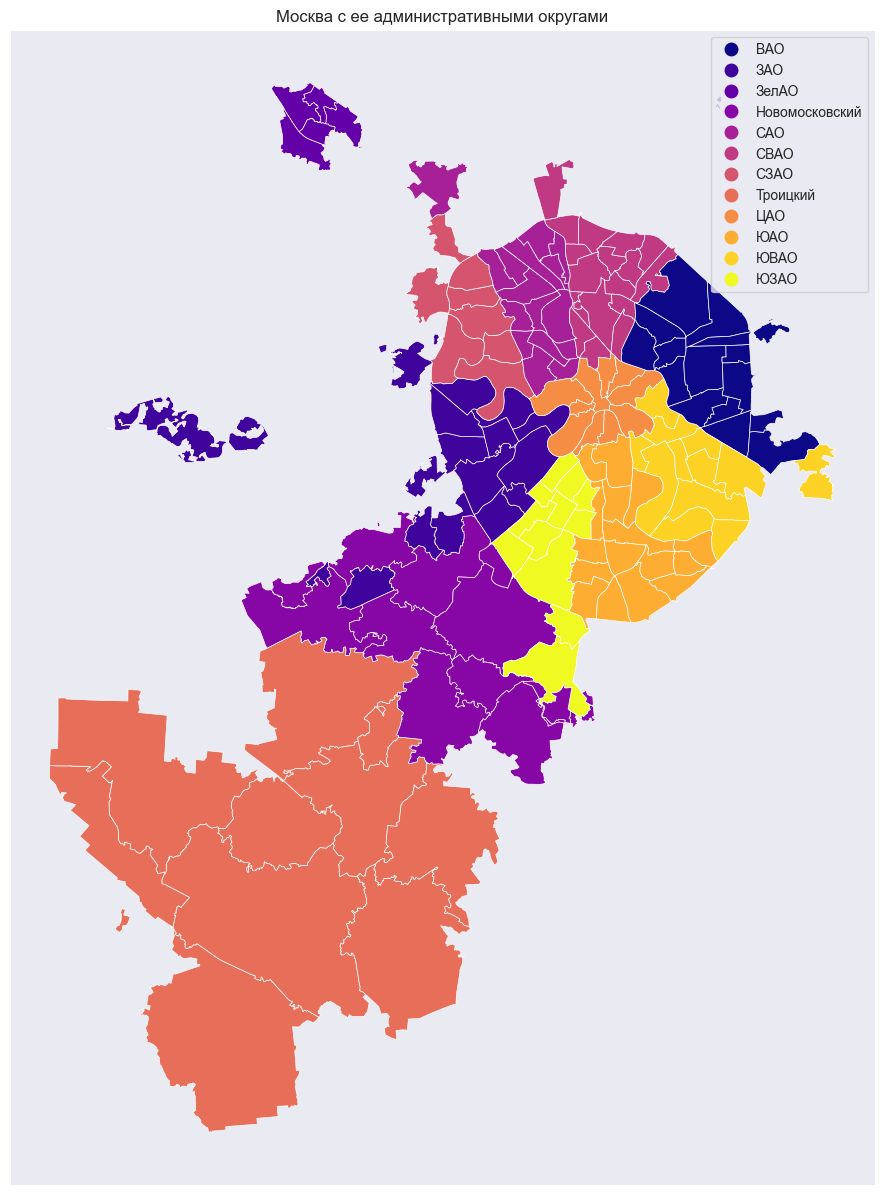

In [19]:
# показать Москву с ее административными округами.
mo_gdf_wm = mo_gdf.to_crs(epsg='3857')
mo_gdf_wm.plot(column = 'ABBREV_AO', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])
plt.xticks([])
plt.yticks([])
plt.title("Москва с ее административными округами")
plt.show()

In [20]:
# определяем административный район, в котором находится указанное здание компании, выставившей вакансию, в случае вне Москвы ставим "Не в Москве"
for dataset in datasets:
    dataset["AO"] = dataset[["lat", "lon"]].apply(lambda row: preprocess.find_AO(row, mo_gdf), axis=1)

In [21]:
# оставить только вакансии из Москвы или с удаленной работой в графике.
in_moscow_or_remote = []
for dataset in datasets:
    filtered_dataset = dataset.loc[(dataset["AO"] != "Не в Москве") | (dataset["schedule"] == "Удаленная работа")]
    in_moscow_or_remote.append(filtered_dataset.reset_index(drop=True))


In [22]:
in_moscow_or_remote[0].describe()

,salary,lat,lon,stations_within_km,distance_to_the_nearest(m)
count,3972.000000,2838.000000,2838.000000,2803.000000,2803.000000
mean,115491.508038,55.717242,37.673687,2.589012,654.900425
std,80418.739531,0.472006,2.919754,2.368945,732.778756
min,200.000000,43.609818,-79.431292,0.000000,0.000000
25%,65000.000000,55.706883,37.540245,1.000000,323.433789
50%,90000.000000,55.749633,37.604655,2.000000,555.481688
75%,150000.000000,55.790504,37.654727,4.000000,817.347094
max,775000.000000,59.945477,104.329484,12.000000,16108.234903


In [23]:
for dataset in in_moscow_or_remote:
    print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3972 entries, 0 to 3971
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   premium                     3972 non-null   bool   
 1   has_test                    3972 non-null   bool   
 2   response_letter_required    3972 non-null   bool   
 3   salary                      3972 non-null   float64
 4   schedule                    3972 non-null   object 
 5   accept_temporary            3972 non-null   bool   
 6   accept_incomplete_resumes   3972 non-null   bool   
 7   experience                  3972 non-null   object 
 8   employment                  3972 non-null   object 
 9   is_adv_vacancy              3972 non-null   bool   
 10  employer_trusted            3972 non-null   bool   
 11  lat                         2838 non-null   float64
 12  lon                         2838 non-null   float64
 13  industry                    3972 

Я имею 7 bool колонок, 5 действительные колонки и 5 категориальные

Для заполнения пустых значений в столбцах stations_within_km, distance_to_the_nearest(m) возьму моду и медиану соотвественно. Для заполнения долготы и широты воспользуюсь медианной.

In [24]:
# заполнение пустых ячеек фрейма
for dataset in in_moscow_or_remote:
    dataset["lat"] = dataset["lat"].fillna(dataset["lat"].median())
    dataset["lon"] = dataset["lon"].fillna(dataset["lon"].median())
    dataset["stations_within_km"] = dataset["stations_within_km"].fillna(dataset["stations_within_km"].mode().iloc[0])
    dataset["distance_to_the_nearest(m)"] = dataset["distance_to_the_nearest(m)"].fillna(dataset["distance_to_the_nearest(m)"].median())

In [25]:
in_moscow_or_remote[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3972 entries, 0 to 3971
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   premium                     3972 non-null   bool   
 1   has_test                    3972 non-null   bool   
 2   response_letter_required    3972 non-null   bool   
 3   salary                      3972 non-null   float64
 4   schedule                    3972 non-null   object 
 5   accept_temporary            3972 non-null   bool   
 6   accept_incomplete_resumes   3972 non-null   bool   
 7   experience                  3972 non-null   object 
 8   employment                  3972 non-null   object 
 9   is_adv_vacancy              3972 non-null   bool   
 10  employer_trusted            3972 non-null   bool   
 11  lat                         3972 non-null   float64
 12  lon                         3972 non-null   float64
 13  industry                    3972 

Все колонки полностью заполнены

### EDA и визуал

Для понимания основных тенденций надо исключить выбросы, так например один бухгалтер с зарплатой 85 млн может помешать увидеть закономерности в графике зарплат

<img alt="Alt text" height="800" src="images\outlier_example.jpg" width="1000"/>{}

In [26]:
# удаление выбросов, чтобы они не влияли на визуализацию.
dataset_without_outliers = []
for dataset in in_moscow_or_remote:
    q_low = dataset["salary"].quantile(0.025)
    q_hi  = dataset["salary"].quantile(0.975)
    dataset_without_outliers.append(dataset[(dataset["salary"] < q_hi) & (dataset["salary"] > q_low)].reset_index(drop=True))
    

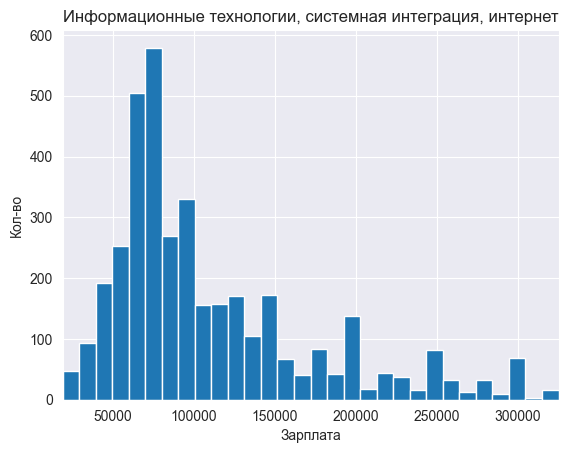

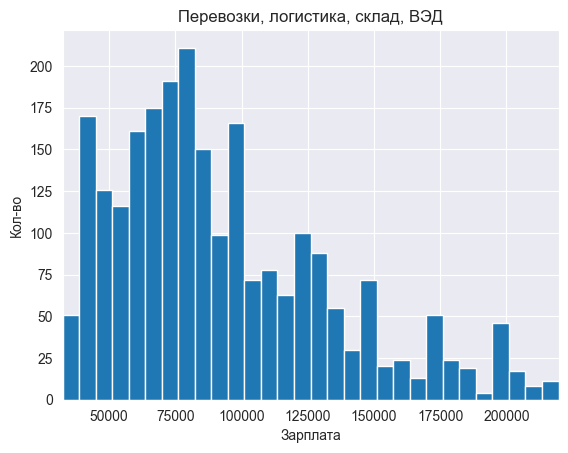

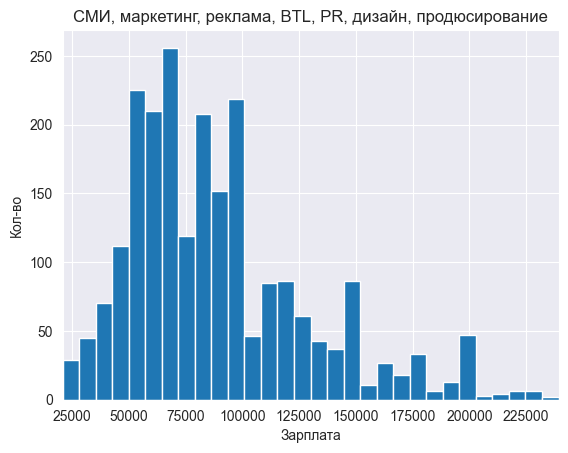

In [27]:
# построить гистограммы зарплат для каждой отрасли.
for dataset in dataset_without_outliers:
    plt.hist(dataset["salary"], 30)
    plt.title(dataset["industry"][0])
    plt.xlim((dataset["salary"].min(), dataset["salary"].max()))
    plt.xlabel("Зарплата")
    plt.ylabel("Кол-во")
    plt.show()

Видно, что графики слегка отличаются. Для более достоверного результата, можно проверить одинаковые ли зарплаты для работников разных отраслей с помощью статистического анализа.

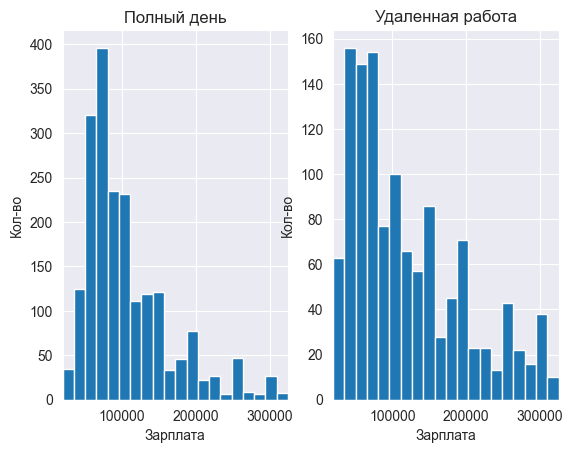

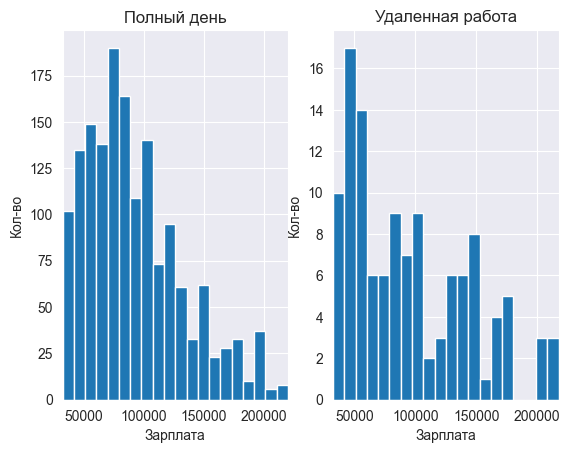

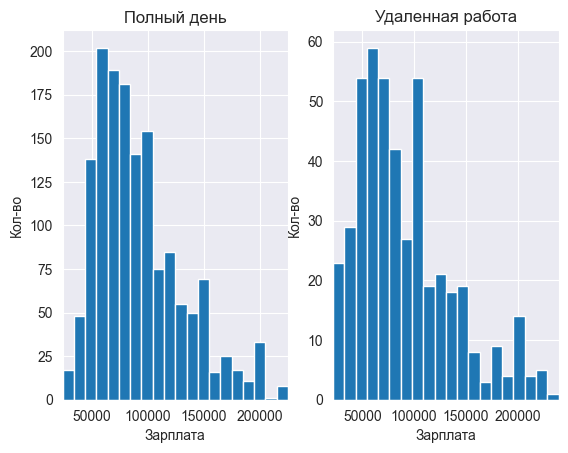

In [28]:
# выводим информацию по вакансиям на удаленку и на полный день
for dataset in dataset_without_outliers:
    in_office = dataset.loc[dataset["schedule"] == "Полный день", "salary"]
    out_office = dataset.loc[dataset["schedule"] == "Удаленная работа", "salary"]
    ax, fig = plt.subplots(ncols=2)
    fig[0].hist(in_office, 20)
    fig[0].set_title("Полный день")
    fig[0].set_xlim((in_office.min(), in_office.max()))
    fig[0].set_xlabel("Зарплата")
    fig[0].set_ylabel("Кол-во")
    fig[1].hist(out_office, 20)
    fig[1].set_title("Удаленная работа")
    fig[1].set_xlim((out_office.min(), out_office.max()))
    fig[1].set_xlabel("Зарплата")
    fig[1].set_ylabel("Кол-во")
    plt.show()

По графикам неочевидно, есть ли отличие между распределением зарплат тех, кто работает полный день в офисе и теми кто не делает так. Различия на графиках могут быть обусловлены особенностями выборки вакансий, поэтому статистический анализ необходим для более точного определения существующих различий или их отсутствия между заработными платами удаленных работников и тех, кто работает в офисе на полный рабочий день.

In [29]:
# какое распределение административных районов имеют вакансии в датасете 0
dataset_without_outliers[0]["AO"].value_counts()

AO
Не в Москве       1035
ЦАО                752
ЮАО                359
САО                298
СВАО               287
ЗАО                236
ВАО                219
ЮЗАО               185
ЮВАО               176
СЗАО               135
Новомосковский      80
Троицкий             5
ЗелАО                3
Name: count, dtype: int64

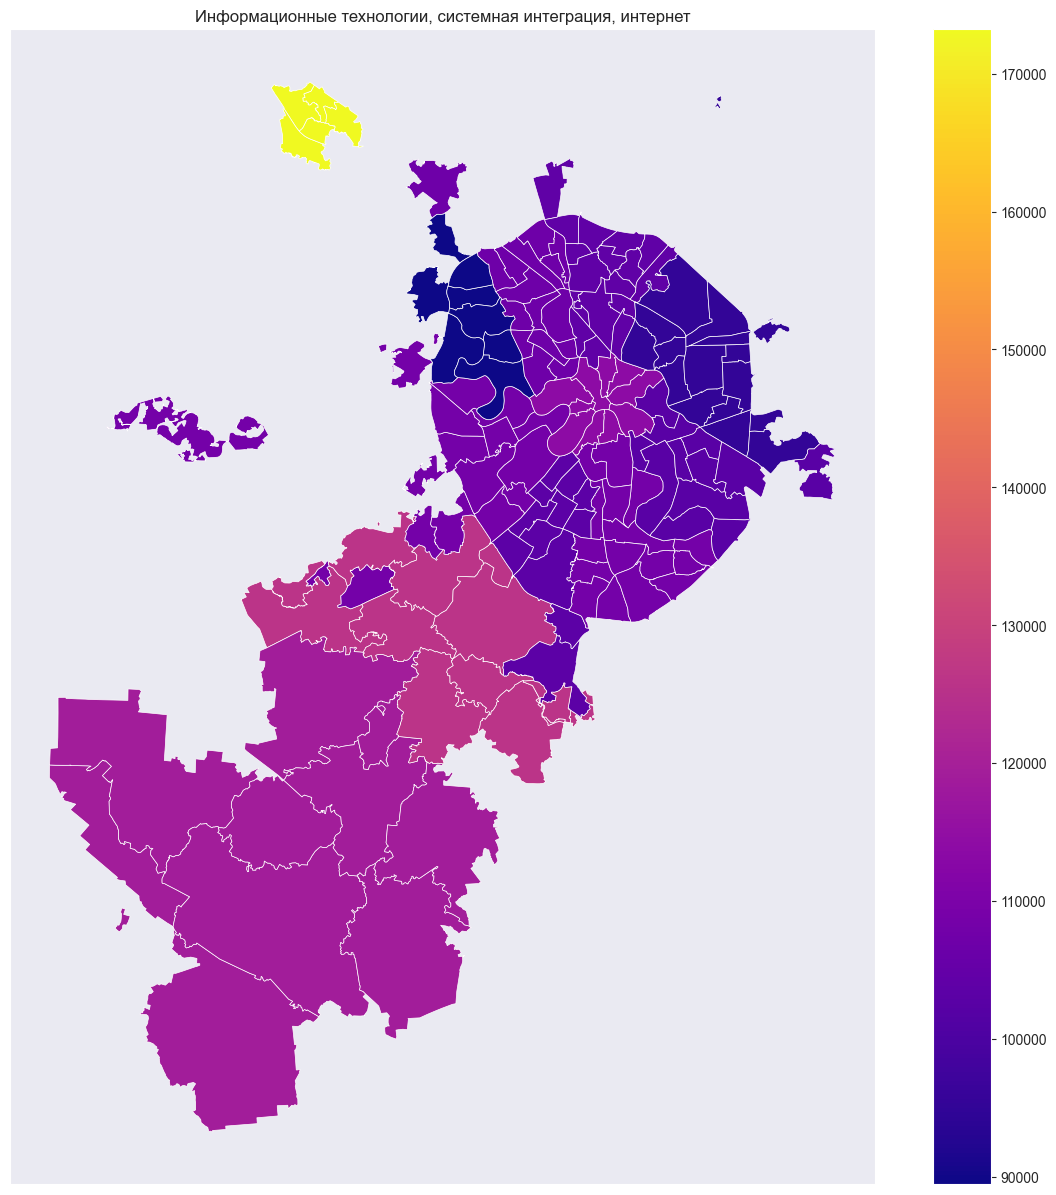

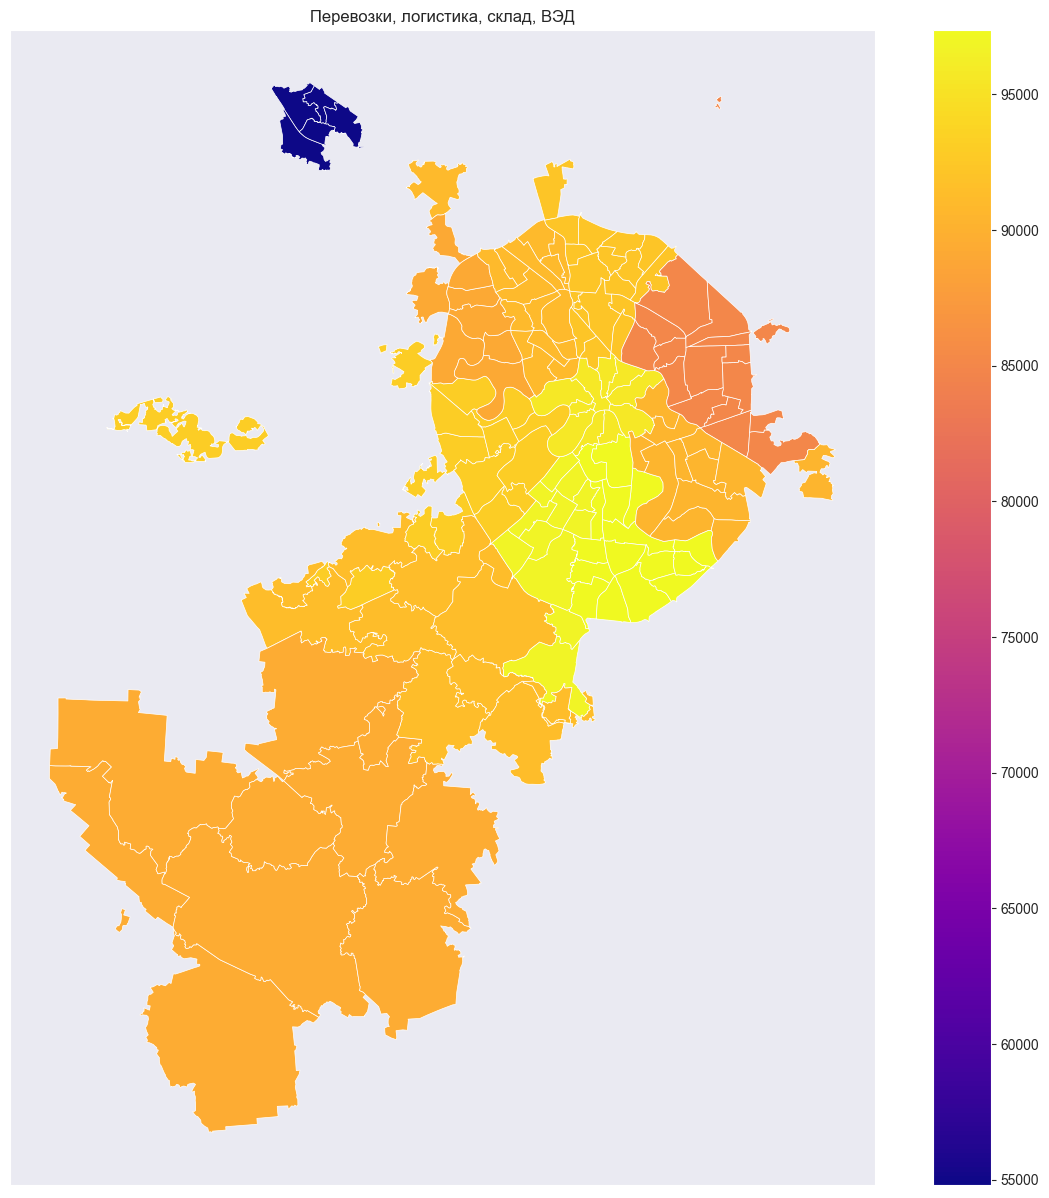

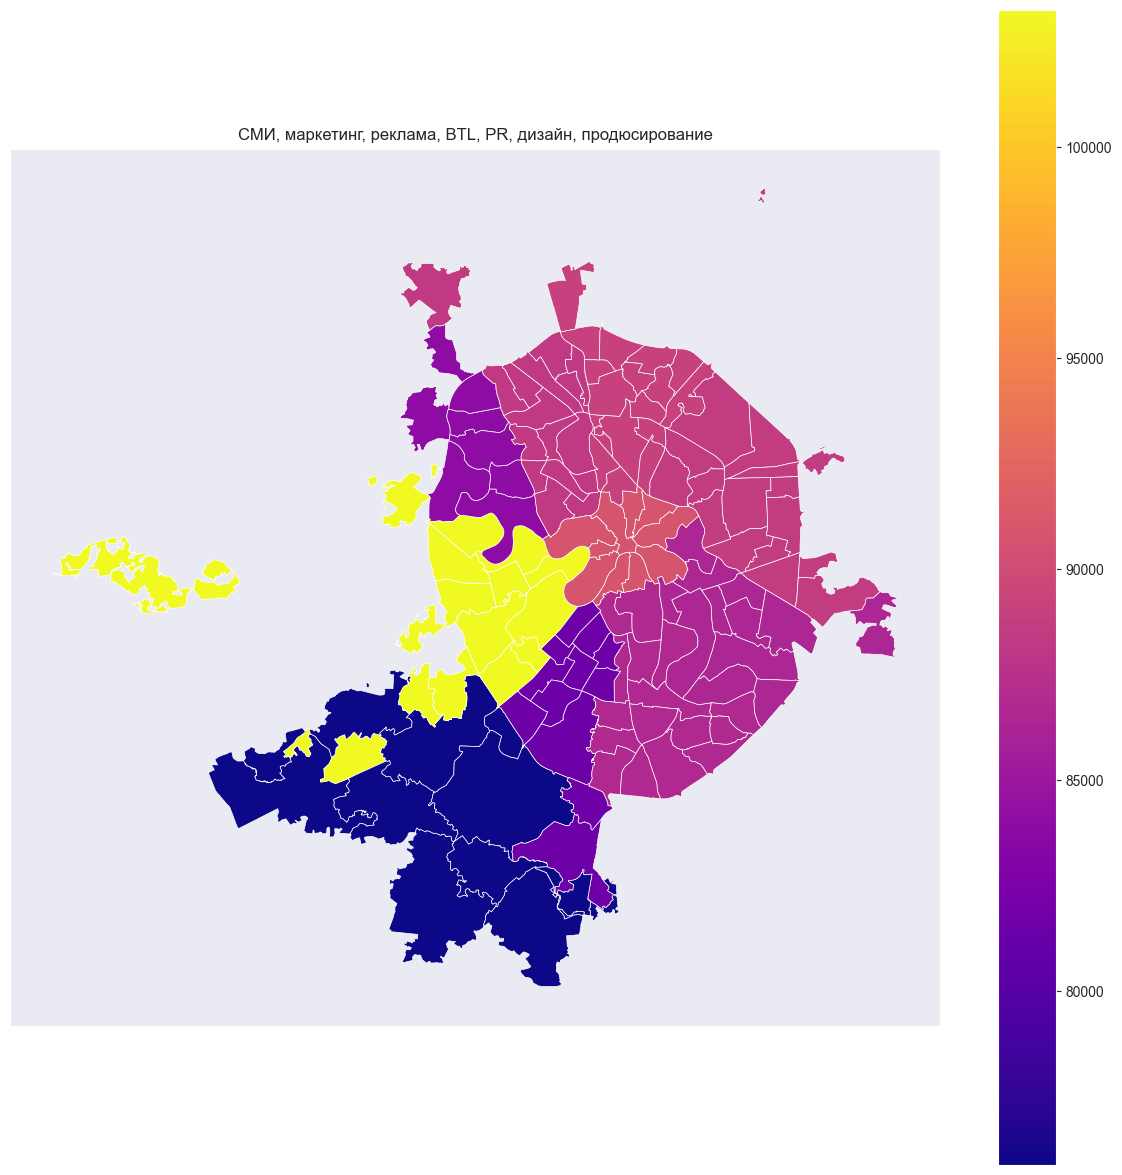

In [30]:
# визуализируем средние указанные зарплаты в вакансиях в административных районах Москвы
visualization.visualize_avg_salary_in_moscow(dataset_without_outliers, mo_gdf)

Зарплата в Москве может отличаться в разных районах и по разным видам работы. Например, в центре города или в IT-сфере она обычно выше, чем в спальных районах или в сфере обслуживания. Поэтому, чтобы понять, сколько можно заработать, нужно учитывать как район, так и вид работы. Так мы можем получить более точную картину и сделать правильные выводы о зарплате в Москве.

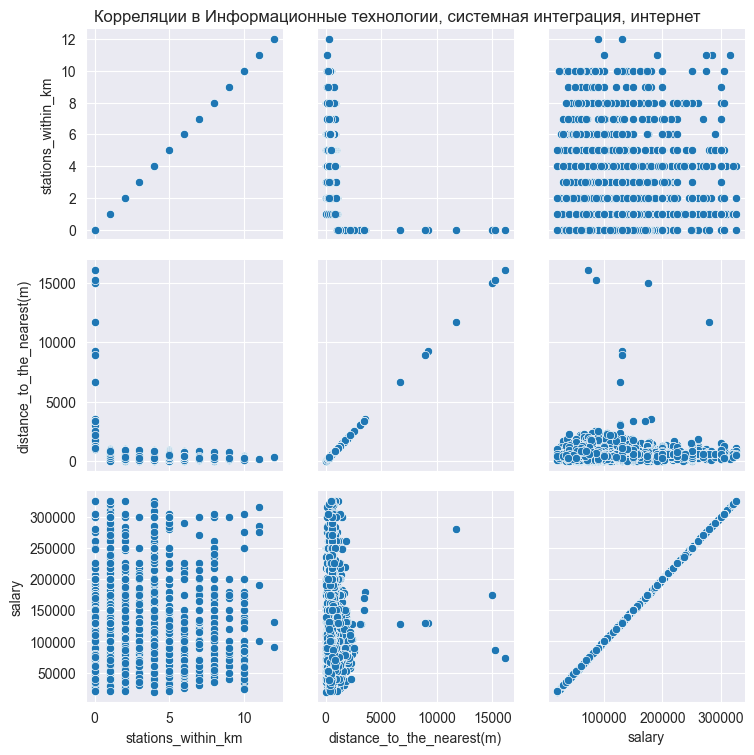

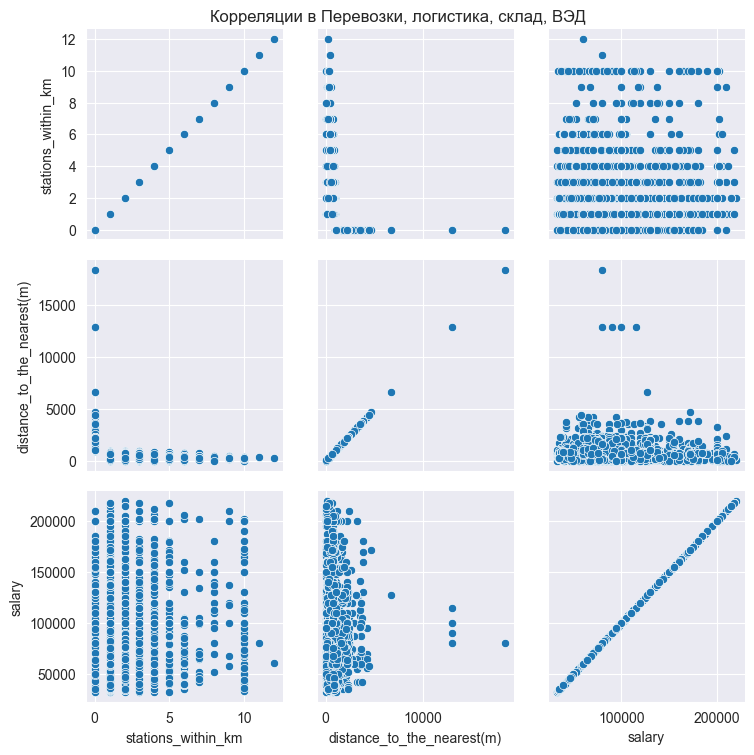

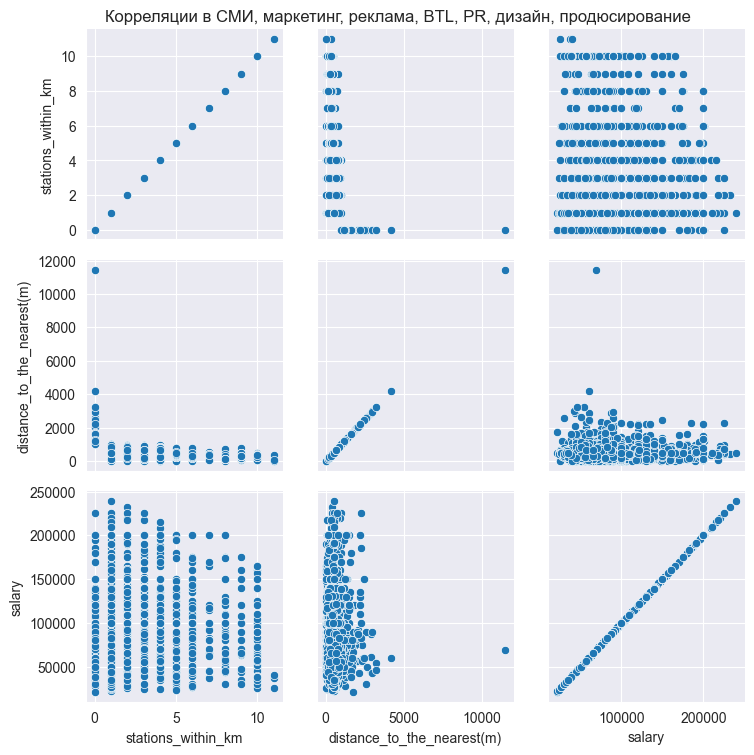

In [31]:
# ищем корреляцию между кол-вом станций, расстоянием до ближайшей станции и зарплатой, используя PairGrid
for dataset in dataset_without_outliers:
    industry = dataset["industry"][0]
    
    pg = sns.PairGrid(dataset[["stations_within_km", "distance_to_the_nearest(m)", "salary"]])
    pg.figure.suptitle(f"Корреляции в {industry}", y=1)
    pg.map(sns.scatterplot)
    

Отсутствует заметная корреляции, мы не наблюдаем определенного паттерна точек на графике, который бы указывал на сильную связь между параметрами. В основном, вакансии имеют значение расстояния от 0 до 2000 метров от ближайшей станции, но это скорее связано с тем, какие вакансии входили в выборку, чем с реальной зависимостью. Если в радиусе 1 км нет метро, то ближайшая станция может быть далеко, что кажется логичным.

Теперь можно посмотреть, люди с каким опытом требуются в разные индустрии. И зависит ли зарплата от опыта работы? Скорее всего зависит, но это нужно проверить.

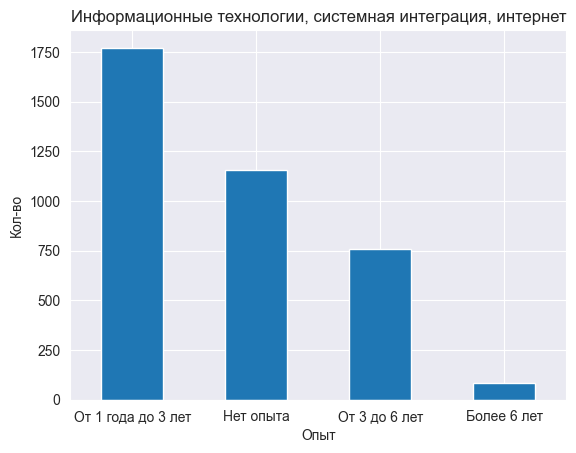

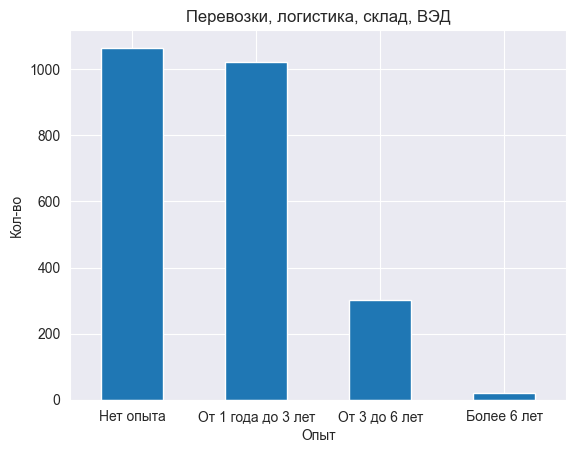

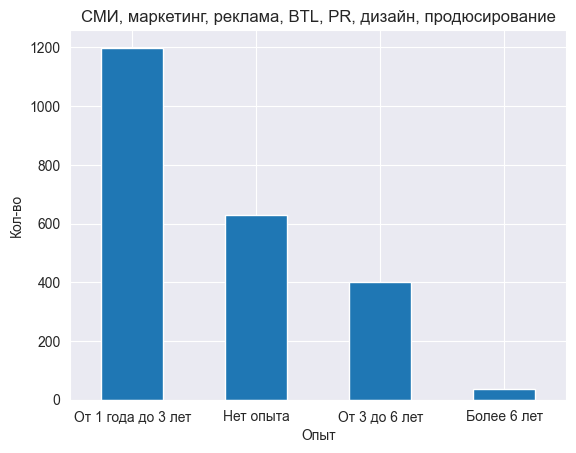

In [32]:
for dataset in dataset_without_outliers:
    exp = {
        "Нет опыта": 0,
        "От 1 года до 3 лет": 0,
        "От 3 до 6 лет": 0,
        "Более 6 лет": 0
    }
    dataset["experience"].value_counts().plot.bar(rot=0)
    plt.title(dataset["industry"][0])
    plt.ylabel("Кол-во")
    plt.xlabel("Опыт")
    plt.show()

По распределению столбцов видно, что большинство вакансий расчитаны на опыт от 1 года до 3 лет, но в других индустриях может быть по-другому, так в перевозках одинаковое кол-во вакансий, не требующих опыта и вакансий с опытом от 1 года до 3 лет.

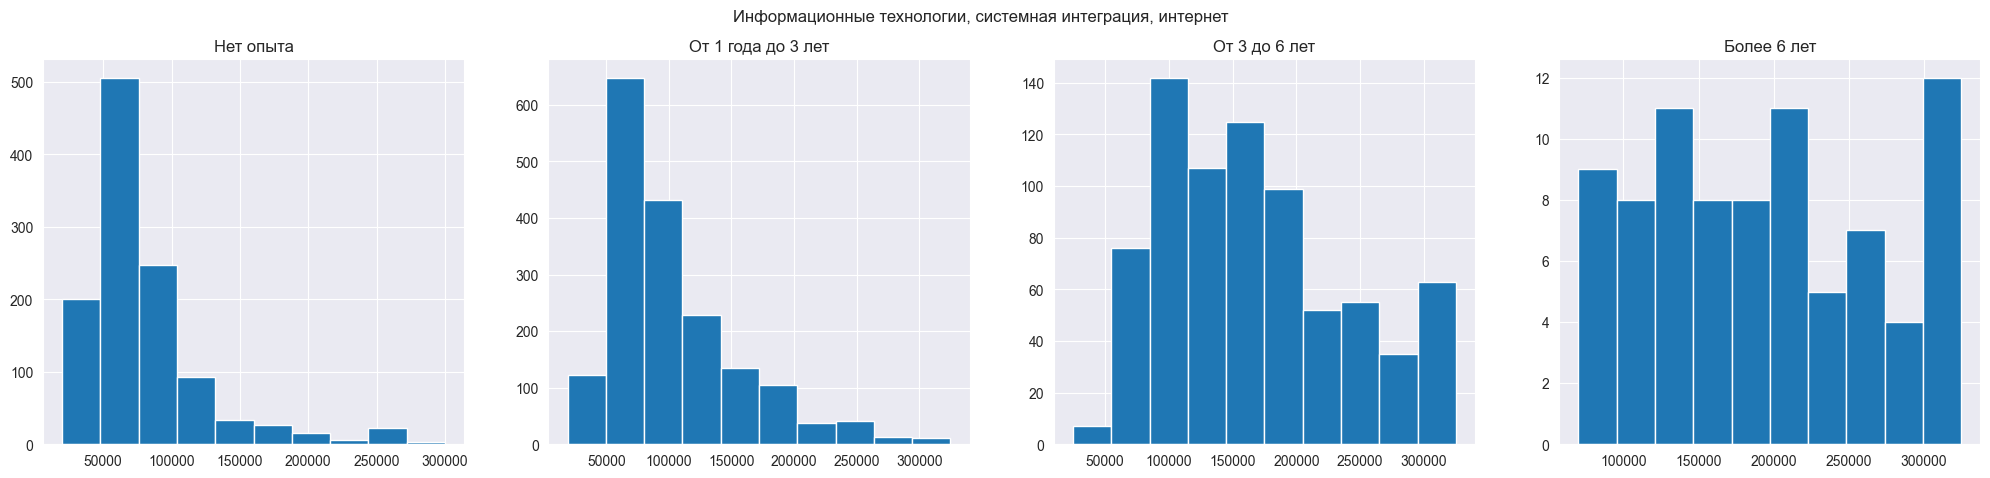

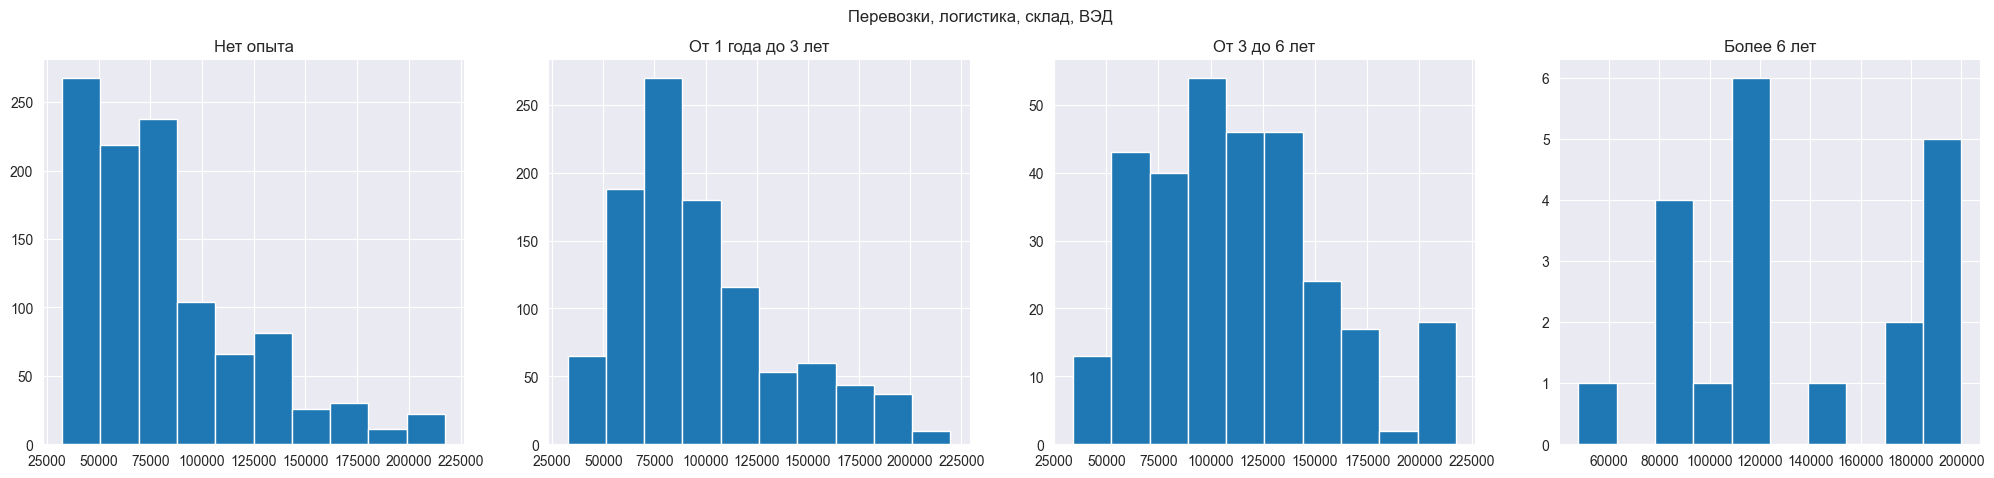

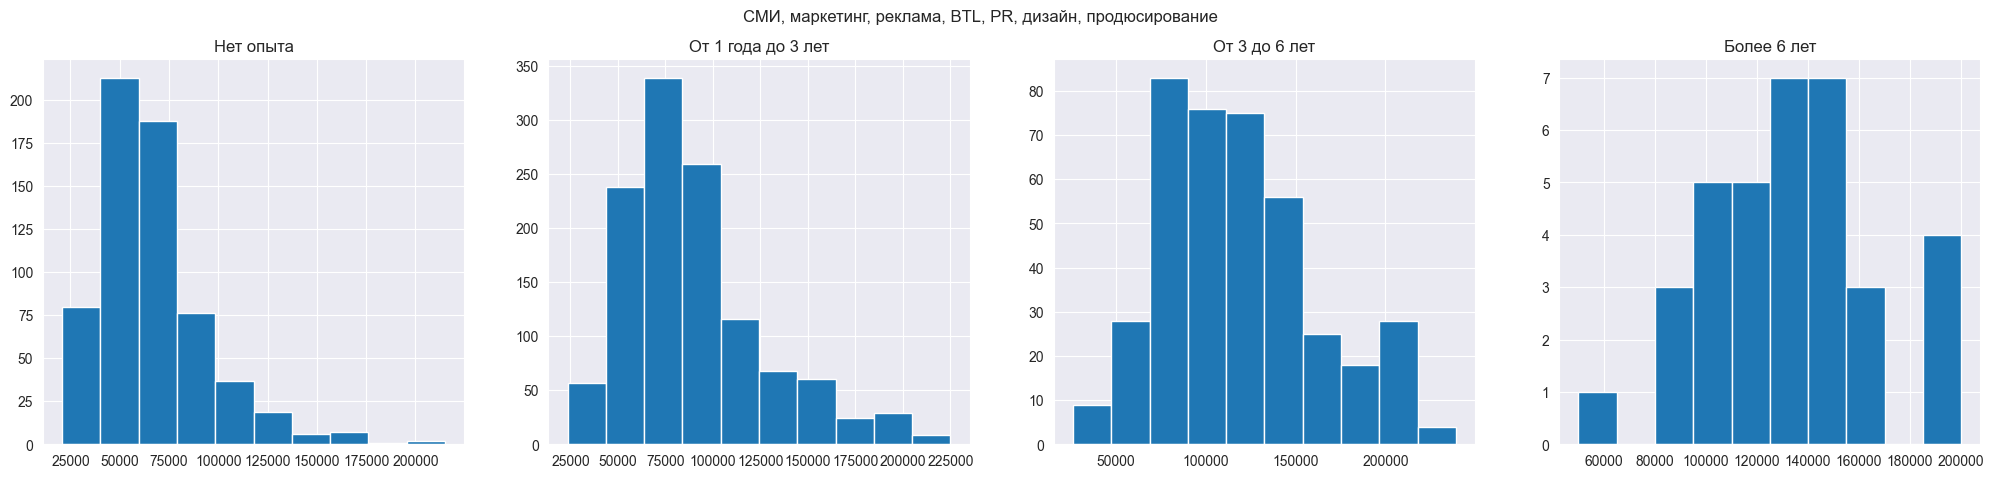

In [33]:
for dataset in dataset_without_outliers:
    _, fig = plt.subplots(ncols=4, figsize=[25,5])
    for i, exp in enumerate(["Нет опыта", "От 1 года до 3 лет", "От 3 до 6 лет", "Более 6 лет"]):
        fig[i].hist(dataset.loc[dataset["experience"]==exp, "salary"], label=exp)
        fig[i].set_title(exp)
    plt.suptitle(dataset["industry"][0])
    plt.show()

Видно, что есть тенденция к увеличению средней зарплаты с большим опытом. Притом в Информационных технологиях и СМИ-маркетинге такая тенденция сохраняется. В других не очевидно, больше ли средняя зарплата у чуть более опытного соискателя.

Булевские переменные

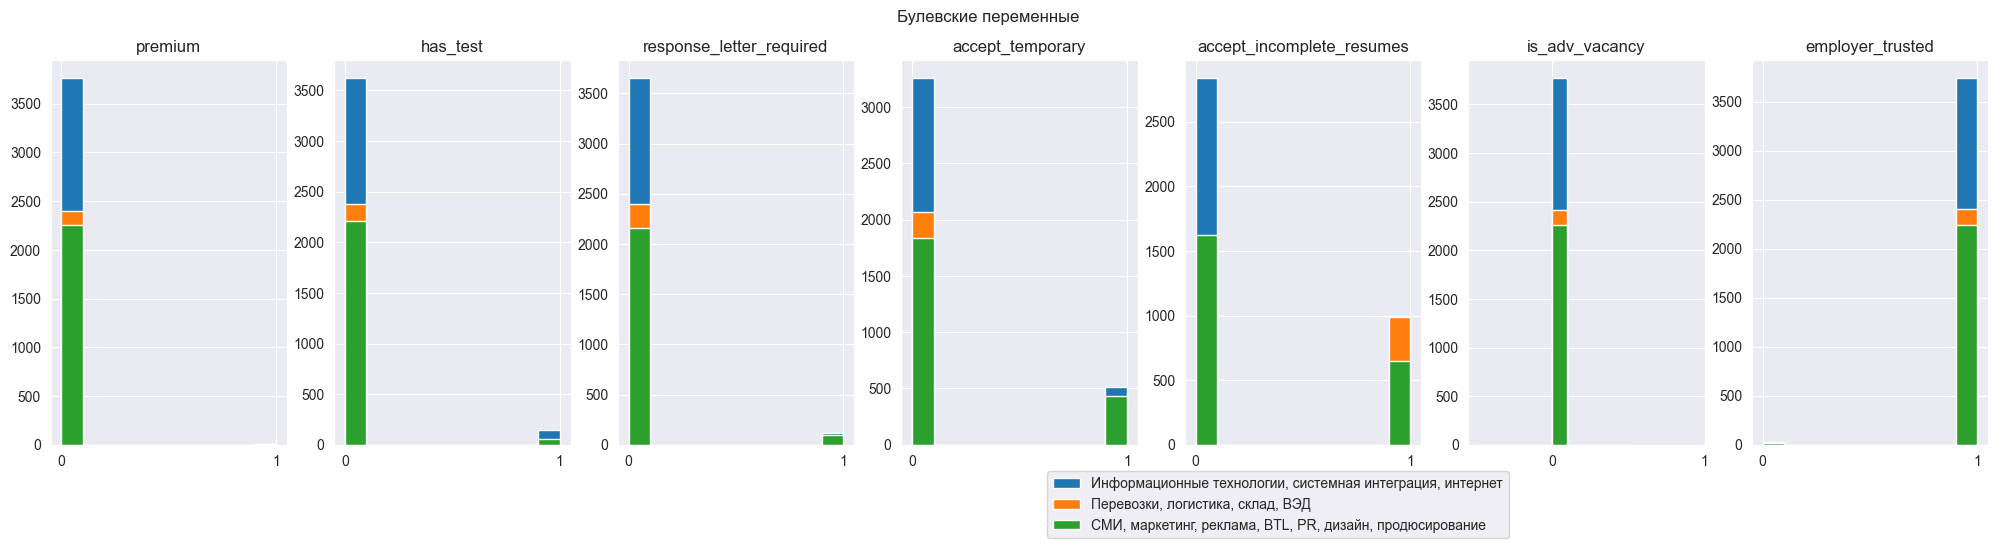

In [34]:
bool_cols = []
for col in dataset_without_outliers[0].columns:
    if dataset_without_outliers[0][col].dtype == bool:
        bool_cols.append(col)
_, fig = plt.subplots(ncols=len(bool_cols), figsize=[25,5])
for dataset in dataset_without_outliers:
    for i, col in enumerate(bool_cols):
        fig[i].hist(dataset[col].apply(lambda x: 1 if x else 0), alpha=1, label=dataset["industry"][0], stacked=True)
    plt.suptitle("Булевские переменные")

for i in range(len(bool_cols)):
    fig[i].set_xticks([0, 1])
    fig[i].set_title(bool_cols[i])
plt.legend(bbox_to_anchor=(-1, -0.05))
plt.show()

Как видно из графиков большинство булевских переменных не сбалансированы, недостаточно наблюдений, чтобы будущая модель по этим параметрам умела предсказывать нужную зарплату на вакансию. Следует удалить данные колонки во избежание ошибок в прогнозировании. 

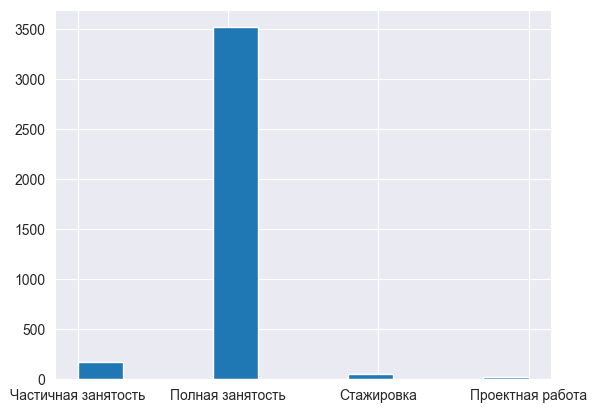

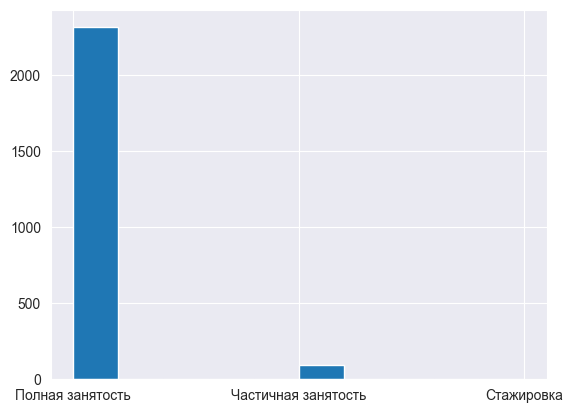

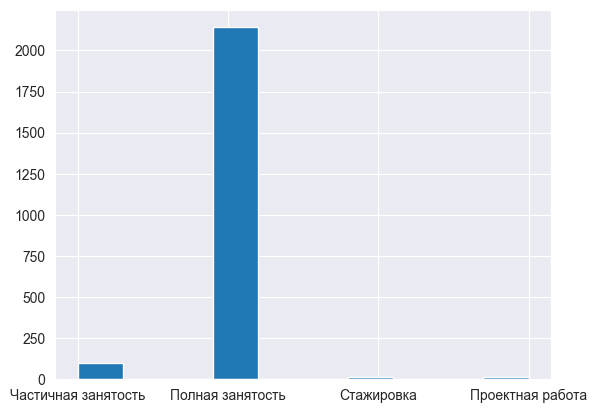

In [35]:
for dataset in dataset_without_outliers:
    plt.hist(dataset["employment"])
    plt.show()

Как видно большая часть вакансий ориентирована на полную занятость. Вероятно, придется объединить более редко встречающиеся типы занятости в "Другое".

### Статистический анализ

In [36]:
import scipy.stats as stats

На этапе исследовательского анализа данных (EDA) мы выявили важные признаки и взаимосвязи между переменными, которые требуется проверить с помощью статистических методов.

Основные вопросы касались зарплаты: мы интересовались различиями в зарплате между разными группами и подгруппами в нашем датасете. Для проверки этих различий можно использовать тесты, направленные на сравнение средних значений зарплат в различных подмножествах данных, такие как ANOVA или тест Краскела-Уоллиса. 

Кроме того, мы хотели определить, как зарплата зависит от таких факторов, как ближайшая станция метро и количество станций в радиусе километра. Для этого можно применить простую линейную модель и проанализировать коэффициенты независимых признаков. Перед этим стоит изучить зависимость между этими признаками, чтобы понять, как они взаимосвязаны.

### Построение модели


В качестве модели можно взять линейную регрессию и дерево решений. Потом сравнить какая модель лучше справляется и выбрать ее.